# Using an SAE as a steering vector

This notebook demonstrates how to use SAE lens to identify a feature on a pretrained model, and then construct a steering vector to affect the models output to various prompts. This notebook will also make use of Neuronpedia for identifying features of interest.

The steps below include:



*   Installing relevant packages (Colab or locally)
*   Load your SAE and the model it used
*   Determining your feature of interest and its index
*   Implementing your steering vector





## Setting up packages and notebook

### Import and installs

#### Environment Setup


In [1]:
try:
  # for google colab users
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens
except:
  # for local setup
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading
PORT = 8000

# general imports
import os
import sys
import torch
from tqdm import tqdm
import plotly.express as px

torch.set_grad_enabled(False);

import copy
import pandas as pd
import itertools as ittl
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datasets import Dataset
from datasets import load_dataset, concatenate_datasets
import transformers


#### General Installs and device setup

In [2]:
# package import
from torch import Tensor
from transformer_lens import utils
from transformers import AutoTokenizer, AutoModelForCausalLM
from functools import partial
from jaxtyping import Int, Float


# device setup
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


### Load your model and SAE

We're going to work with a pretrained GPT2-small model, and the RES-JB SAE set which is for the residual stream.

In [3]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
# layer = 0

# get model
model = HookedTransformer.from_pretrained("gpt2-small", device = device)

# # get the SAE for this layer
# '''
# sae, cfg_dict, _ = SAE.from_pretrained(
#     release = "gemma-2b-res-jb",
#     sae_id = f"blocks.{layer}.hook_resid_post",
#     device = device
# )
# '''
# sae, cfg_dict, _ = SAE.from_pretrained(
#     release = "gpt2-small-res-jb",
#     sae_id = f"blocks.{layer}.hook_resid_pre",
#     device = device
# )

# # get hook point
# hook_point = sae.cfg.hook_name
# print(hook_point)

/home/jovyan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


## Determine your feature of interest and its index

### Find your feature

#### Explore through code by using the feature activations for a prompt

For the purpose of the tutorial, we are selecting a simple token prompt.

In this example we will look trying to find and steer a "Jedi" feature.

We run our prompt on our model and get the cache, which we then use with our sae to get our feature activations.

Now we'll look at the top feature activations and look them up on Neuronpedia to determine what they have been intepreted as.

In [5]:
# print('dir(sae)\n', dir(sae))
# print('sae.W_enc.shape\n', sae.W_enc.shape)

# print('\n')

# #sv_prompt = " The Golden Gate Bridge"
# # sv_prompt = 'Jedi'
# sv_prompt = 'Emily\'s dog just died. She is feeling sad'
# # sv_prompt = 'John\'s lunch was stolen. He is feeling angry'
# # sv_prompt = 'John just received a present. He is feeling happy'

# sv_logits, cache = model.run_with_cache(sv_prompt, prepend_bos=True)
# tokens = model.to_tokens(sv_prompt)
# print('tokens', tokens)

# # get the feature activations from our SAE
# sv_feature_acts = sae.encode(cache[hook_point])

# # get sae_out
# sae_out = sae.decode(sv_feature_acts)

# # print out the top activations, focus on the indices
# print('\n', torch.topk(sv_feature_acts, 3))


# # Explanation of the topk outputs below:
# # There are 5 tokens in sv_prompt: <BOS>, The, Golden, Gate, Bridge. 
# # So what topk is showing is for each token what SAE feature is being activated the most.
# # Thats why we have a 5 x 3 array. 


### Set up hook functions

Finally, we need to create a hook that allows us to apply the steering vector when our model runs generate() on our defined prompt. We have also added a boolean value 'steering_on' that allows us to easily toggle the steering vector on and off for each prompt


In [4]:
def steering_hook(resid_pre, hook):

    if resid_pre.shape[1] == 1:
        return

    # print('resid_pre.shape', resid_pre.shape)
    position = sae.W_dec.shape[-1]
    # print('sae_out.shape', sae_out.shape, '\n')
    if steering_on:
      # using our steering vector and applying the coefficient

      # So here resid_pre are the values from the residual stream (in this case [batch_size, n_tokens, 768])
      # We modify all values up to but not including the last token (since its an EOS token)

      # Modification is an addition of the outgoing weights from the target SAE feature 
      # (which is a size 768 vector) multiplied by a coefficient that controls the magnitude of the steering

      # The steered values would then make their way through the rest of the model
      resid_pre[:, :position - 1, :] += coeff * steering_vector

def ablation_hook(resid_pre, hook):

    if resid_pre.shape[1] == 1:
        return
    
    if steering_on:

        position = sae.W_dec.shape[-1]
    
        act_strength = (resid_pre @ sae.W_enc)[:, :position-1, feature_id]
        act_strength = torch.unsqueeze(act_strength, -1)
        new_shape = list(act_strength.shape)
        new_shape[-1] = steering_vector.shape[-1]
        act_strength.expand(new_shape)

        resid_pre[:, :position-1, :] -= act_strength * steering_vector

def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=30,
            do_sample=True,
            **kwargs)
    return result


In [5]:
def run_generate(prompts, n_samples, steering_type='steer'):
  
  res_list = []

  for prompt, label in prompts:

    model.reset_hooks()

    # Steering
    editing_hooks = [(f"blocks.{layer}.hook_resid_pre", steering_hook)] if steering_type == 'steer' \
                    else [(f"blocks.{layer}.hook_resid_pre", ablation_hook)]

    res = hooked_generate([prompt] * n_samples, editing_hooks, seed=None, **sampling_kwargs)

    # Print results, removing the ugly beginning of sequence token
    res_str = model.to_string(res[:, 1:])
    res_str = [(text.split('\". '))[1] for text in res_str]
    res_list.append({'prompt': prompt, 'responses': res_str, 'label': label})

  return pd.DataFrame(res_list)

## Implement your steering vector and affect the output

### Define values for your steering vector
To create our steering vector, we now need to get the decoder weights from our sparse autoencoder found at our index of interest.

Then to use our steering vector, we want a prompt for text generation, as well as a scaling factor coefficent to apply with the steering vector

We also set common sampling kwargs - temperature, top_p and freq_penalty

In [154]:
# Golden State Bridge:
# steering_vector = sae.W_dec[10200]

# Jedi:
# steering_vector = sae.W_dec[7650]

# Sadness: 2442, 
# steering_vector = sae.W_dec[2442]

# Anger: 1550, 4707, 18357, 5526, 21165, 252
# steering_vector = sae.W_dec[21165]

# Worry: 849, 15524, 18978, 21673
# steering_vector = sae.W_dec[18978]

# Happiness: 13928, 3879, 3456
# steering_vector = sae.W_dec[24422]
# sampling_kwargs = dict(temperature=0.9, top_p=0.1, freq_penalty=1.0)

### Loading an Emotion Recognition Dataset - https://github.com/dair-ai/emotion_dataset

In [6]:
emotion_dataset = load_dataset('dair-ai/emotion', split='train', trust_remote_code=True)

In [7]:
emotion_dataset = emotion_dataset.shuffle(seed=42)

In [8]:
# Split dataset into partitions based on label
parted_dataset = [emotion_dataset.filter(lambda x: x['label'] == label) for label in range(len(emotion_dataset.features['label'].names))]

In [9]:
print(parted_dataset[0])

Dataset({
    features: ['text', 'label'],
    num_rows: 4666
})


In [10]:
# batch_size will take batch_size number of samples from each class, awkward naming but whatever
batch_size = 5
batch = concatenate_datasets([part.select([x for x in range(batch_size)]) for part in parted_dataset])
print(batch)
# prompts = [f'Jennifer says, \"{text}\". Jennifer feels' for text in batch['text']]
prompts = [f'Alex says, \"{text}\". Alex feels' for text in batch['text']]
labels = [label for label in batch['label']]
prompts = list(zip(prompts, labels))

Dataset({
    features: ['text', 'label'],
    num_rows: 30
})


### Getting a "judge" model to judge the generations

In [11]:
sampling_kwargs = dict(temperature=0.5, top_p=0.1, freq_penalty=5.0)
n_samples = 1
steer_type = 'steer'
coeff = 15
feature_id = 22318
steering_vector = sae.W_dec[feature_id]

NameError: name 'sae' is not defined

In [181]:
steering_on = False
default_generation = run_generate(prompts, n_samples, steering_type=steer_type)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [205]:
steering_on = True
steered_generation = run_generate(prompts, n_samples, steering_type=steer_type)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
emotion_features = {

    'layer_0':
    {
        'sadness': [12266, 23208, 14158, 10882, 10510, 546], 
        'joy': [8699, 10924, 13808, 16670, 15464, 1432], 
        'love': [24486, 19618, 3970, 7792, 13985, 21219, 4892, 7099],
        'anger': [22318, 13668, 17628, 12030, 800, 22574],
        'fear': [2998, 8167, 634, 22447, 15196, 8194, 2288, 13200, 23219, 4783, 6938],
        'surprise': [8279, 2031, 5029, 14386, 16023, 15694],
    },

    'layer_1':
    {
        'sadness': [8174, 15771, 24104, 8419], 
        'joy': [18120, 23750, 17653, 6284, 11250, 24040, 7683, 3591], 
        'love': [3091, 14230, 6847, 4332, 150],
        'anger': [20851, 13745, 10403, 11541, 4194],
        'fear': [5186, 6767, 20821, 23954, 21612, 21153, 19325, 6146, 21826],
        'surprise': [12718, 23779, 18239, 666, 487, 16125, 8551, 2037],
    },

    'layer_2':
    {
        'sadness': [11683, 14915, 11568, 4350, 2442], 
        'joy': [7796, 23405, 22134, 3456, 13928, 3879, 23476], 
        'love': [3203],
        'anger': [11085, 21027, 14918, 252, 21165, 4707, 1550, 5526, 18357],
        'fear': [24422, 22815, 21011, 20309, 18350, 10882, 9937, 5843, 12026],
        'surprise': [11631, 11365, 15076, 10353, 7902, 7800],
    },

    'layer_3':
    {
        'sadness': [24140, 24469, 22098, 14290], 
        'joy': [10739, 9828, 14625, 5329, 19341, 10990, 6001], 
        'love': [14981, 5501, 15927, 11815, 23271],
        'anger': [13819, 9272, 412, 3213, 16043, 24133],
        'fear': [6134, 1861, 22236, 8135, 20126, 20648, 2253, 20588, 18762, 9805, 8914, 6653],
        'surprise': [3282, 23140, 10647, 972, 17827, 3625, 17365, 14434, 10958],
    },

    'layer_4':
    {
        'sadness': [5179, 7494, 9341, 22033, 23292, 10051], 
        'joy': [15968, 12298, 9569, 8244, 22722], 
        'love': [9757, 10750, 4004, 7249],
        'anger': [22695, 9072, 18320, 11510, 3810, 16080, 15004, 11183],
        'fear': [20655, 18321, 13386, 4338, 2955, 24553, 16651, 15882, 14836, 12290],
        'surprise': [19514, 15250, 19967, 16649, 24019, 12758, 9661],
    },

    'layer_5':
    {
        'sadness': [1265, 22889], 
        'joy': [6803, 17170, 14404, 1255, 13678, 14997], 
        'love': [23060, 12473, 3674, 18288, 13689, 4600, 3448],
        'anger': [1773, 330, 5136, 9706, 9559],
        'fear': [7952, 15844, 6801, 21689, 24318, 2212, 5990, 15747],
        'surprise': [21258, 14750, 2877, 3055, 17557, 23920, 3546, 16559, 9884, 7516, 6011],
    },

    'layer_6':
    {
        'sadness': [20719, 251], 
        'joy': [9995, 3020, 18199, 14968, 203, 2617], 
        'love': [19727, 16022, 11397, 14808],
        'anger': [20521, 16530, 10131, 6415, 15780, 21846],
        'fear': [3246, 5289, 12900, 20520, 18781, 2459, 20211, 19068, 6685, 2260],
        'surprise': [13502, 18954, 14477, 6315, 9678, 2328, 21364, 17678, 9978, 19798, 3036],
    },

    'layer_7':
    {
        'sadness': [2045], 
        'joy': [24314, 17025, 19547], 
        'love': [2887, 2715, 19662],
        'anger': [1776, 10033],
        'fear': [18892, 13863, 17128, 13519, 4505, 5211, 17463, 19010, 15862, 14791],
        'surprise': [17837, 20417, 17104, 12344, 8002, 10849, 15668, 11750, 8981, 8442],
    },

    'layer_8':
    {
        'sadness': [7473, 3927], 
        'joy': [13624, 8708, 13433], 
        'love': [8631, 9837, 2017],
        'anger': [21519, 22715, 2133, 17121],
        'fear': [13796, 4846, 8887, 4810, 19414, 19585, 17376],
        'surprise': [14571, 1366, 14856, 15950, 15512, 20821, 8855, 12456, 20423, 4939],
    },

    'layer_9':
    {
        'sadness': [10885, 17773, 5000], 
        'joy': [4288, 7702, 20850, 1418, 4864], 
        'love': [20105, 9946, 17442, 21303, 21876],
        'anger': [21253, 7002, 15510, 16663],
        'fear': [20233, 19535, 5563, 1413, 15382, 14412],
        'surprise': [21445, 21532, 10719, 14851, 24082, 16180, 1167, 14205, 7831, 17898, 1655],
    },

    'layer_10':
    {
        'sadness': [11363], 
        'joy': [4091, 5713, 809], 
        'love': [10165, 14654, 20694, 19070, 130, 2095],
        'anger': [14697, 5203, 19957],
        'fear': [24358, 20305, 18367, 6822, 6260, 2783],
        'surprise': [2150, 9733, 23922, 23723, 7658, 184, 18509, 20367, 14901, 6227],
    },

    'layer_11':
    {
        'sadness': [3334, 24428, 16896], 
        'joy': [4943, 8946], 
        'love': [12316, 6390, 6694, 15057, 4407],
        'anger': [21754, 12214, 8427, 20367, 14410],
        'fear': [13374, 9550, 24256, 14324, 13554, 165, 12092, 9703, 20934],
        'surprise': [22471, 5047, 22203, 17670, 17411, 17777, 5820, 949, 12189, 4452, 15556, 3086, 21799],
    },

}



### Attempts at LLMs as Oracles

In [26]:
emotion_labels = emotion_dataset.features['label'].names
# judge_prompt = f'For each of the following emotions: {emotion_labels}, rate '
emotions = ", ".join(emotion_labels)
print(emotions, '\n')
# judge_prompt = f'For the following text: {example_response}, which of the following emotions: {emotions}, does John feel?'
# judge_prompt = f'For the following text: \"{steered_example[0]}\", what does John feel?'
# judge_prompt = f'Given the following text: \"{steered_example[0]}\", what does John feel? John feels'

# example_idx = 0

# default_example = default_generation.iloc[example_idx]['responses'][0]
# steered_example = steered_generation.iloc[example_idx]['responses'][0]

# print(default_generation.iloc[example_idx]['prompt'])
# print(default_example)
# print(list(set(default_generation.iloc[example_idx]['prompt'].split(' ')) & set(default_example.split(' '))))
# print()
# print(steered_generation.iloc[example_idx]['prompt'])
# print(steered_example)
# print(list(set(steered_generation.iloc[example_idx]['prompt'].split(' ')) & set(steered_example.split(' '))))

sadness, joy, love, anger, fear, surprise 



In [197]:

# model_id = "meta-llama/Meta-Llama-3-8B"

# tokenizer = AutoTokenizer.from_pretrained(model_id)
# judge_model = AutoModelForCausalLM.from_pretrained(model_id)

# pipeline = transformers.pipeline(
#     "text-generation",
#     model=model_id,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device=device,
#     return_full_text=False,
# )
# pipeline.tokenizer.pad_token_id = judge_model.config.eos_token_id

In [14]:
# Constrained generation
from guidance import models
from guidance import select

guided_model = models.Transformers('meta-llama/Meta-Llama-3-8B', device_map={"": 0})

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
# # Import few-shot prompt

# # label_map = {'(a)': 'sadness', '(b)': 'joy', '(c)': 'love', '(d)': 'anger', '(e)': 'fear', '(f)': 'surprise'}
# label_map = {'(a)': 0, '(b)': 1, '(c)': 2, '(d)': 3, '(e)': 4, '(f)': 5}

# # new_prompt = f"\n\n---\n\nText:\n\\'\'\'\n{default_example}\n\\'\'\'\nLabel: "

prompt_file = open('fewshot1.txt', 'r')

judge_fewshot = prompt_file.read()
judge_prompt = judge_fewshot + new_prompt

prompt_file.close()

NameError: name 'new_prompt' is not defined

In [15]:
# from guidance import select

# # lm = guided_model + judge_prompt + select(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)'], name='choice')
# lm = guided_model + judge_prompt + select(emotion_labels, name='choice')

NameError: name 'judge_prompt' is not defined

In [58]:
print(lm['choice'])

fear


### Default responses from GPT2 (no steering, annotation done by Llama 3 - 8B)

In [16]:
def annotate_responses(generation):

    annotation_df = generation.copy(deep=True)
    annotation_df['responses'] = np.empty(annotation_df['responses'].size, dtype=str)
    annotation_df = annotation_df.rename(columns={'responses': 'prediction'})

    for i, row in generation.iterrows():

        row_annotations = pd.Series(n_samples, dtype=int)

        judge_prompts = []
        for j, response in enumerate(row['responses']):

            new_prompt = f"\n\n---\n\nText:\n\\'\'\'\n{response}\n\\'\'\'\nLabel: "
            # guided_res = guided_model + judge_fewshot + new_prompt + select(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)'], name='choice')
            guided_res = guided_model + judge_fewshot + new_prompt + select(emotion_labels, name='choice')
            row_annotations[j] = guided_res['choice']
        
        # annotation = label_map[(row_annotations.mode())[0]]
        annotation = (row_annotations.mode())[0]
        annotation_df.loc[i, "prediction"] = annotation

    return annotation_df

In [17]:
# def annotate_responses(generation):

#     annotation_df = generation.copy(deep=True)
#     annotation_df['responses'] = np.empty(annotation_df['responses'].size, dtype=str)
#     annotation_df = annotation_df.rename(columns={'responses': 'prediction'})

#     for i, row in generation.iterrows():

#         row_annotations = pd.Series(n_samples, dtype=int)

#         judge_prompts = []
#         for j, response in enumerate(row['responses']):

#             new_prompt = f"\n\n---\n\nText:\n\\'\'\'\n{response}\n\\'\'\'\nLabel: "
#             guided_res = guided_model + judge_fewshot + new_prompt + select(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)'], name='choice')
#             row_annotations[j] = guided_res['choice']
#             # judge_prompts.append(judge_fewshot + new_prompt)

#         # judge_prompts = Dataset.from_list(judge_prompts)
#         # outputs = pipeline(
#         #             judge_prompts,
#         #             max_new_tokens=3,
#         #             eos_token_id=terminators,
#         #             do_sample=True,
#         #             temperature=0.1,
#         #             top_p=0.1,
#         #             batch_size=len(judge_prompts)
#         #             )   
                    
#         # try:
#         #     row_annotations = pd.Series([label_map[item[0]['generated_text'][1:4]] for item in outputs])
#         # except:
#         #     print('error getting annotation')
#         #     debug = open('debug.txt', 'a')
#         #     debug.write(str(judge_prompts))
#         #     debug.close()
#         # annotation = label_map[outputs[0]['generated_text'][1:4]]
#         # row_annotations[j] = annotation
#         annotation = label_map[(row_annotations.mode())[0]]
#         # Add annotation to annotation_df
#         # annotation_df['prediction'][i] = annotation
#         annotation_df.loc[i, "prediction"] = annotation

#     return annotation_df


In [18]:
default_preds = annotate_responses(default_generation)

NameError: name 'default_generation' is not defined

In [207]:
steered_preds = annotate_responses(steered_generation)

/tmp/ipykernel_32363/515263311.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'anger' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  row_annotations[j] = guided_res['choice']


In [23]:
def fill_missing_labels(series: pd.Series):

    # labels = [0, 1, 2, 3, 4, 5]
    labels = emotion_labels
    missing = []
    for label in labels:
        if label not in series.index:
            missing.append(label)
            
    missing = pd.Series([0 for _ in range(len(missing))], index=missing)

    return pd.concat([series, missing]) if not(missing.empty) else series

In [208]:
# Fill in missing labels if necessary 

real_distr = default_preds['label'].value_counts(sort=False)
print(real_distr.index)
# real_distr = real_distr.reindex(sorted(real_distr.index))
real_distr.index = emotion_labels


default_distr = fill_missing_labels(default_preds['prediction'].value_counts(sort=False))
# default_distr = default_distr.reindex(sorted(default_distr.index))
default_distr = default_distr.reindex(emotion_labels)

steered_distr = fill_missing_labels(steered_preds['prediction'].value_counts(sort=False))
# steered_distr = steered_distr.reindex(sorted(steered_distr.index))
steered_distr = steered_distr.reindex(emotion_labels)


Index([0, 1, 2, 3, 4, 5], dtype='int64', name='label')


In [209]:
print(real_distr.index)

Index(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], dtype='object')


In [210]:
plot_df = pd.DataFrame([real_distr, default_distr, steered_distr]).transpose()
plot_df.columns = ['real', 'default', 'steered']
print(plot_df)

          real  default  steered
sadness      5        6        0
joy          5        4        0
love         5        5        0
anger        5        6       30
fear         5        9        0
surprise     5        0        0


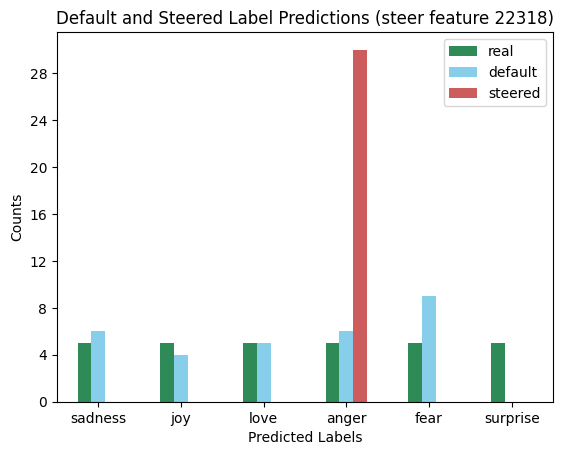

In [211]:
# df = pd.DataFrame({"Example one":yesSeries,"Example two":nodSeries})
ax = plot_df.plot.bar(color=["SeaGreen", "SkyBlue","IndianRed"], rot=0, title=f"Default and Steered Label Predictions ({steer_type} feature {feature_id})")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Counts")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [224]:
# Calculate Jensen-Shannon Divergence for real labels vs default predictions

js_dis = distance.jensenshannon(default_distr, steered_distr)
print(js_dis)

0.6502387678692824


### Go through emotion related features and check ablation effects on prediction 

In [19]:
# batch_size will take batch_size number of samples from each class, awkward naming but whatever
batch_size = 15
batch = concatenate_datasets([part.select([x for x in range(batch_size)]) for part in parted_dataset])
print(batch)
# prompts = [f'Jennifer says, \"{text}\". Jennifer feels' for text in batch['text']]
prompts = [f'Alex says, \"{text}\". Alex feels' for text in batch['text']]
labels = [label for label in batch['label']]
prompts = list(zip(prompts, labels))

Dataset({
    features: ['text', 'label'],
    num_rows: 90
})


In [28]:
ablation_effects = copy.deepcopy(emotion_features)
steer_20_effects = copy.deepcopy(emotion_features)
sampling_kwargs = dict(temperature=0.5, top_p=0.1, freq_penalty=5.0)
n_samples = 1
coeff = 20
steer_type = 'ablate'
target_layer = 0

# Get default distribution
steering_on = False
default_generation = run_generate(prompts, n_samples, steering_type=steer_type)
default_preds = annotate_responses(default_generation)
default_distr = fill_missing_labels(default_preds['prediction'].value_counts(sort=False))
default_distr = default_distr.reindex(emotion_labels)
    

steering_on = True
for layer_idx, layer_name in enumerate(ablation_effects.keys()):

    layer = layer_idx

    # Load SAE for this layer
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gpt2-small-res-jb",
        sae_id = f"blocks.{layer_idx}.hook_resid_pre",
        device = device
        )

    # get hook point
    hook_point = sae.cfg.hook_name

    for emotion in ablation_effects[layer_name]:
        
        steer_type = 'ablate'
        for j, feature_num in enumerate(ablation_effects[layer_name][emotion]):

            feature_id = feature_num
            steering_vector = sae.W_dec[feature_num]
            
            # Do generation
            responses = run_generate(prompts, n_samples, steering_type=steer_type)

            # Do annotation
            annotations = annotate_responses(responses)

            # Get distribution
            new_distr = fill_missing_labels(annotations['prediction'].value_counts(sort=False))
            new_distr = new_distr.reindex(emotion_labels)

            # Get JS distance
            js_distance = distance.jensenshannon(default_distr, new_distr)

            # Replace value in dict
            ablation_effects[layer_name][emotion][j] = (feature_num, js_distance)
        
        steer_type = 'steer'
        coeff = 20
        for j, feature_num in enumerate(steer_20_effects[layer_name][emotion]):

            feature_id = feature_num
            steering_vector = sae.W_dec[feature_num]
              
            # Do generation
            responses = run_generate(prompts, n_samples, steering_type=steer_type)

            # Do annotation
            annotations = annotate_responses(responses)

            # Get distribution
            new_distr = fill_missing_labels(annotations['prediction'].value_counts(sort=False))
            new_distr = new_distr.reindex(emotion_labels)

            # Get JS distance
            js_distance = distance.jensenshannon(default_distr, new_distr)

            # Replace value in dict
            steer_20_effects[layer_name][emotion][j] = (feature_num, js_distance)


        

/tmp/ipykernel_904/515263311.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'fear' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  row_annotations[j] = guided_res['choice']


NameError: name 'pickle' is not defined

In [29]:
import pickle

In [30]:
with open(f'ablation_effect_all_layers.pkl', 'wb') as f:
    pickle.dump(ablation_effects, f)

with open(f'steer_20_effect_all_layers.pkl', 'wb') as f:
    pickle.dump(steer_20_effects, f)

In [32]:
with open(f'ablation_effect_all_layers.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    print(loaded_dict)

{'layer_0': {'sadness': [(12266, 0.05920798421448489), (23208, 0.092545568777795), (14158, 0.10598818985199403), (10882, 0.08441380089022585), (10510, 0.042430235470293294), (546, 0.09506236271362445)], 'joy': [(8699, 0.06013792769847593), (10924, 0.05442534221522403), (13808, 0.14422535808526082), (16670, 0.0972270243966704), (15464, 0.06801962236531685), (1432, 0.07907644240058859)], 'love': [(24486, 0.04199374843362757), (19618, 0.07785277366991186), (3970, 0.0738154339558306), (7792, 0.1090845437855492), (13985, 0.07359145043270564), (21219, 0.060694505838899786), (4892, 0.12055547402890134), (7099, 0.06485527517976264)], 'anger': [(22318, 0.07140873140508561), (13668, 0.11260909246796945), (17628, 0.136993132323818), (12030, 0.08207058533001868), (800, 0.1336924728991583), (22574, 0.06984331557150779)], 'fear': [(2998, 0.08669878258234977), (8167, 0.08839673501064112), (634, 0.10288922697877087), (22447, 0.10043814345398534), (15196, 0.10198877668693447), (8194, 0.1503271416717931

In [263]:
print(steer_20_effects)

{'layer_0': {'sadness': [12266, 23208, 14158, 10882, 10510, 546], 'joy': [8699, 10924, 13808, 16670, 15464, 1432], 'love': [24486, 19618, 3970, 7792, 13985, 21219, 4892, 7099], 'anger': [22318, 13668, 17628, 12030, 800, 22574], 'fear': [2998, 8167, 634, 22447, 15196, 8194, 2288, 13200, 23219, 4783, 6938], 'surprise': [8279, 2031, 5029, 14386, 16023, 15694]}, 'layer_1': {'sadness': [8174, 15771, 24104, 8419], 'joy': [18120, 23750, 17653, 6284, 11250, 24040, 7683, 3591], 'love': [3091, 14230, 6847, 4332, 150], 'anger': [20851, 13745, 10403, 11541, 4194], 'fear': [5186, 6767, 20821, 23954, 21612, 21153, 19325, 6146, 21826], 'surprise': [12718, 23779, 18239, 666, 487, 16125, 8551, 2037]}, 'layer_2': {'sadness': [11683, 14915, 11568, 4350, 2442], 'joy': [7796, 23405, 22134, 3456, 13928, 3879, 23476], 'love': [3203], 'anger': [11085, 21027, 14918, 252, 21165, 4707, 1550, 5526, 18357], 'fear': [24422, 22815, 21011, 20309, 18350, 10882, 9937, 5843, 12026], 'surprise': [11631, 11365, 15076, 103

In [246]:
print(ablation_effects)

{'layer_0': {'sadness': [12266, 23208, 14158, 10882, 10510, 546], 'joy': [8699, 10924, 13808, 16670, 15464, 1432], 'love': [24486, 19618, 3970, 7792, 13985, 21219, 4892, 7099], 'anger': [22318, 13668, 17628, 12030, 800, 22574], 'fear': [2998, 8167, 634, 22447, 15196, 8194, 2288, 13200, 23219, 4783, 6938], 'surprise': [8279, 2031, 5029, 14386, 16023, 15694]}, 'layer_1': {'sadness': [8174, 15771, 24104, 8419], 'joy': [18120, 23750, 17653, 6284, 11250, 24040, 7683, 3591], 'love': [3091, 14230, 6847, 4332, 150], 'anger': [20851, 13745, 10403, 11541, 4194], 'fear': [5186, 6767, 20821, 23954, 21612, 21153, 19325, 6146, 21826], 'surprise': [12718, 23779, 18239, 666, 487, 16125, 8551, 2037]}, 'layer_2': {'sadness': [11683, 14915, 11568, 4350, 2442], 'joy': [7796, 23405, 22134, 3456, 13928, 3879, 23476], 'love': [3203], 'anger': [11085, 21027, 14918, 252, 21165, 4707, 1550, 5526, 18357], 'fear': [24422, 22815, 21011, 20309, 18350, 10882, 9937, 5843, 12026], 'surprise': [11631, 11365, 15076, 103

In [247]:
print(str(sys.getsizeof(emotion_features)), 'bytes')

640 bytes


In [222]:
import pickle 

In [249]:

with open(f'ablation_effect_layer_{target_layer}.pkl', 'wb') as f:
    pickle.dump(ablation_effects, f)
        
with open(f'ablation_effect_layer_{target_layer}.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    ablation_layer_4_effects = np.array([n for e in loaded_dict[f'layer_{target_layer}'] for _, n in loaded_dict['layer_4'][e]])


In [256]:
with open(f'steer_20_effect_layer_{target_layer}.pkl', 'wb') as f:
    pickle.dump(steer_20_effects, f)
        
with open(f'steer_20_effect_layer_{target_layer}.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    steer_20_layer_4_effects = np.array([n for e in loaded_dict['layer_4'] for _, n in loaded_dict['layer_4'][e]])
    scatter_plt_labels = np.array([e for e in loaded_dict['layer_4'] for _, n in loaded_dict['layer_4'][e]])


In [257]:
print(scatter_plt_labels)

['sadness' 'sadness' 'sadness' 'sadness' 'sadness' 'sadness' 'joy' 'joy'
 'joy' 'joy' 'joy' 'love' 'love' 'love' 'love' 'anger' 'anger' 'anger'
 'anger' 'anger' 'anger' 'anger' 'anger' 'fear' 'fear' 'fear' 'fear'
 'fear' 'fear' 'fear' 'fear' 'fear' 'fear' 'surprise' 'surprise'
 'surprise' 'surprise' 'surprise' 'surprise' 'surprise']


### REMEMBER TO CHANGE NAMES

In [1]:
# Create a colormap
cmap = plt.get_cmap('plasma')
unique_plt_labels = list(set(scatter_plt_labels))
colors = [cmap(i / len(unique_plt_labels)) for i in range(len(unique_plt_labels))]
color_map = dict(zip(unique_plt_labels, colors))

# Plotting the scatter plot with colored labels
plt.figure(figsize=(12, 12))
for label in unique_plt_labels:
    idx = np.where(scatter_plt_labels == label)
    plt.scatter(ablation_layer_4_effects[idx], steer_20_layer_4_effects[idx], color=color_map[label], label=label)

# Create legend
plt.legend()

# Adding labels to each point (uncomment if needed)
# for i in range(len(ablation_layer_0_effects)):
#     plt.text(ablation_layer_0_effects[i], steer_20_layer_0_effects[i], scatter_plt_labels[i], fontsize=10, ha='right')

plt.xlabel('Ablation')
plt.ylabel('Steering (coeff = 20)')
plt.title('Scatter Plot with Colored Labels')
plt.savefig('layer_0_effects.png', bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined